In [5]:
%matplotlib inline
import lightkurve as lk
from lightkurve_ext import download_lightcurvefiles

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy.io import fits

In [6]:
# Likely to be a false positive
tic = 284990199

# Load the light_curves into collection
lcf_coll = download_lightcurvefiles(f"TIC{tic}", mission='TESS', download_dir='./data')
print(len(lcf_coll))


1


In [7]:
# search_res = lk.search.search_lightcurvefile(f"TIC{tic}", mission='TESS')
# search_res.table


In [8]:
def lcf_of_sector(lcf_coll, sectorNum):
    for lcf in lcf_coll:
        if lcf.header()['SECTOR'] == sectorNum:
            return lcf
    return None


In [9]:
def plot_lcf_flux_delta(lcf, ax, xmin=None, xmax=None):
    # default plot text properties
    matplotlib.rcParams.update({'font.size':36}) 
    matplotlib.rcParams.update({'font.family':'sans-serif'})
    
    # possible input arguments
    moving_avg_window = '1h'    
    lc = lcf.PDCSAP_FLUX.normalize(unit='percent')

    # Basic scatter of the observation
    ax = lc.scatter(ax=ax)
    
    # convert to dataframe to add moving average
    df = lc.to_pandas(columns=['time', 'flux'])
    df['time_ts'] = df['time'].apply(lambda x: pd.Timestamp(x, unit='D'))
    # the timestamp above is good for relative time.
    # if we want the timestamp to reflect the actual time, we need to convert the BTJD in time to timetamp, e.g.
    # df['time_ts'] = df['time'].apply(lambda x: pd.Timestamp(astropy.time.Time(x + 2457000, format='jd', scale='tdb').datetime.timestamp(), unit='s'))
    df['flux_mavg'] = df.rolling(moving_avg_window, on='time_ts')['flux'].mean()
    ax.plot(lc.time, df['flux_mavg'], c='black', label=f"Moving average ({moving_avg_window})")
        
#      df['flux_delta'] = df.rolling(moving_avg_window, on='time_ts')['flux_mavg'].apply(lambda vary: vary[-1] - vary[0], raw=True)
#     ax.plot(lc.time, df['flux_delta'], c='blue', label=f"Flux delta ({moving_avg_window})")    

    ax.set_xlim(xmin, xmax)
    
    return ax

if False: 
    fig = plt.figure(figsize=(30,15))
    plot_lcf_flux_delta(lcf_of_sector(lcf_coll, 5), fig.gca()
    #                     , xmin=1452, xmax=1458
                       )


Sectors: [14]


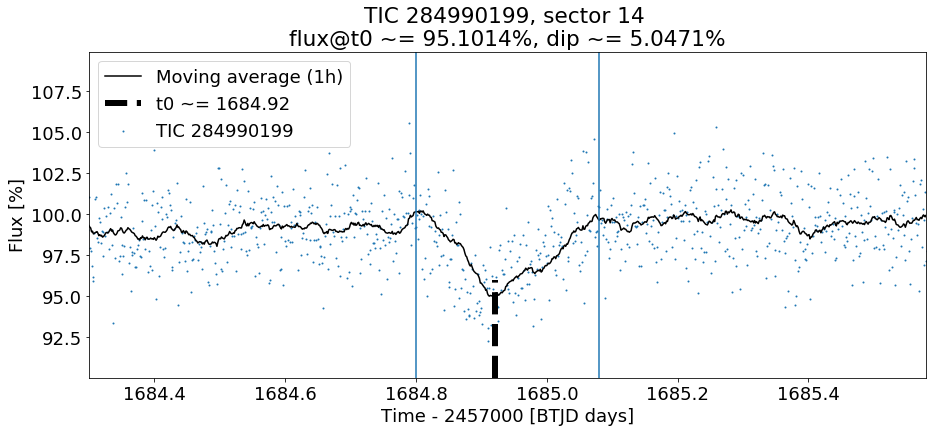

In [10]:
# default plot text properties
matplotlib.rcParams.update({'font.size':36}) 
matplotlib.rcParams.update({'font.family':'sans-serif'})

def lcf_fig():
    return plt.figure(figsize=(15, 6))

def flux_near(lc, time):
    if time is None or lc is None:
        return None
    else: 
        idx = (np.abs(lc.time - time)).argmin()
        return lc.flux[idx]

def flux_mavg_near(df, time):
    if time is None or df is None:
        return None
    else: 
        idx = (np.abs(df['time'].values - time)).argmin()
        # must use df.iloc[idx]['flux_mavg'], rather than df['flux_mavg'][idx] 
        # because dataframe from lightkurve is indexed by time (rather than regular 0-based index)
        # df.iloc[] ensures we can still access the value by 0-based index
        return df.iloc[idx]['flux_mavg']
    
def as_4decimal(float_num):
    if (float_num is None):
        return None
    else: 
        return '{0:.4f}'.format(float_num)

def plot_n_annotate_lcf(lcf, ax, xmin=None, xmax=None, t0=None, t_start=None, t_end=None):
    if lcf == None:
        print("Warning: lcf is None. Plot skipped")
        return
    
    # possible input arguments
    moving_avg_window = '1h'    
    lc = lcf.PDCSAP_FLUX.normalize(unit='percent')
    
    # Basic scatter of the observation
    ax = lc.scatter(ax=ax)
    
    # convert to dataframe to add moving average
    df = lc.to_pandas(columns=['time', 'flux'])
    df['time_ts'] = df['time'].apply(lambda x: pd.Timestamp(x, unit='D'))
    # the timestamp above is good for relative time.
    # if we want the timestamp to reflect the actual time, we need to convert the BTJD in time to timetamp, e.g.
    # df['time_ts'] = df['time'].apply(lambda x: pd.Timestamp(astropy.time.Time(x + 2457000, format='jd', scale='tdb').datetime.timestamp(), unit='s'))
    df['flux_mavg'] = df.rolling(moving_avg_window, on='time_ts')['flux'].mean()    
    plt.plot(lc.time, df['flux_mavg'], c='black', label=f"Moving average ({moving_avg_window})")
    
    
    # annotate the graph
    lcfh = lcf.header()
    if xmin is None and t_start is not None:
        xmin = t_start - 0.5
    if xmax is None and t_end is not None:
        xmax = t_end + 0.5
    ax.set_xlim(xmin, xmax)
    if t_start is not None:
        ax.axvline(t_start)
    if t_end is not None:
        ax.axvline(t_end)
    if t0 is not None:
        ax.axvline(t0, ymin=0, ymax=0.3, color='black', linewidth=6, linestyle='--', label=f"t0 ~= {t0}")
            
    flux_t0 = flux_mavg_near(df, t0)
    flux_dip = None
    if flux_t0 is not None:
        flux_begin = max(flux_mavg_near(df, t_start), flux_mavg_near(df, t_end))
        flux_dip = flux_begin - flux_t0
    ax.set_title(f"{lc.label}, sector {lcfh['SECTOR']} \nflux@t0 ~= {as_4decimal(flux_t0)}%, dip ~= {as_4decimal(flux_dip)}%")
    ax.legend()
    return ax

# Do the actual plots
def plot_all(lcf_coll): 
    matplotlib.rcParams.update({'font.size':36}) 
    matplotlib.rcParams.update({'font.family':'sans-serif'})
    ax_all = plt.figure(figsize=(30, 15)).gca()
    # choice 1: use the built-in plot method
#     lcf_coll.PDCSAP_FLUX.plot(ax=ax_all) # Or lcf_coll.SAP_FLUX.plot()
                 
    # choice 2: stitch lightcurves of the collection together, and then use more flexible methods, e.g., scatter
    #   Note: pass lambda x: x to stitch() so that the code won't normalize the flux value sector by sector
#     lc_all = lcf_coll.PDCSAP_FLUX.stitch(lambda x: x) 
#     lc_all.scatter(ax=ax_all, normalize=True)

    # choice 3: plot the lightcurve sector by sector: each sector has its own color                 
#     for i in range(0, len(lcf_coll)):
#         lcf_coll[i].PDCSAP_FLUX.scatter(ax=ax_all)

#     ax_all.set_title(f"TIC {lcf_coll[0].PDCSAP_FLUX.label}, sectors {list(map(lambda lcf: lcf.header()['SECTOR'], lcf_coll))}")
#     return ax_all

    # choice 4: plot the lightcurve sector by sector: each sector in its own graph
    for i in range(0, len(lcf_coll)):
        ax = lcf_fig().gca()
        lcf_coll[i].PDCSAP_FLUX.scatter(ax=ax, normalize=True)
        ax.set_title(f"TIC {lcf_coll[0].PDCSAP_FLUX.label}, sectors {lcf_coll[i].header()['SECTOR']}")
                 
    return None

def plot_selected(lcf_coll):                      
    matplotlib.rcParams.update({'font.size':18}) 
    matplotlib.rcParams.update({'font.family':'sans-serif'})
    # only sector 14 for now
    plot_n_annotate_lcf(lcf_of_sector(lcf_coll, 14), ax=lcf_fig().gca()
                        , t0=1684.92, t_start=1684.80, t_end=1685.08
                       )
#     print(f"Period ~= {as_4decimal(1622.5 - 1538.6)} days")
    return 

                     
# plot_all(lcf_coll)

# likely to be a contanimation of eclipsing binaries,
# 1. the dip is V-shaped
# 2. centroid offsets from vetting summary also indicated so: https://www.zooniverse.org/projects/nora-dot-eisner/planet-hunters-tess/talk/2110/1127610?comment=1853815&page=1
plot_selected(lcf_coll)

print("Sectors: " + str(list(map(lambda lcf: lcf.header()['SECTOR'], lcf_coll))))


In [11]:
print(list(map(lambda lc: lc.header()['SECTOR'], lcf_coll)))
print(list(map(lambda lc: lc.header()['CAMERA'], lcf_coll)))
print(list(map(lambda lc: lc.header()['DATE-OBS'], lcf_coll)))


[14]
[1]
['2019-07-18T20:19:29.942Z']


In [12]:
# combine all the observations together
# or I can just use lcf_coll.stich()
lc = None
for i in range(0, len(lcf_coll)):
    lc_cur = lcf_coll[i].get_lightcurve('PDCSAP_FLUX')
    if lc == None:
        lc = lc_cur    
    else:
        lc.append(lc_cur, inplace=True)
    
print(len(lc.time))

for i in range(0, len(lcf_coll)):
    lc_cur = lcf_coll[i].get_lightcurve('PDCSAP_FLUX')
    print(f"  Sector {lcf_coll[i].header()['SECTOR']}: {lc_cur.time.min()} - {lc_cur.time.max()}")

print(lc.time.max()  - lc.time.min())

# use the interactive transit period detection
#   caveat: un-sure if combining observations over time make sense for the algorithm
lc.interact_bls()


18522
  Sector 14: 1683.3579835514413 - 1710.2078160403423
26.84983248890103
